In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [61]:
data = np.load('board_grade.npy', allow_pickle=True)

In [62]:
x, y = data[:, 1], data[:, 0]

In [63]:
for i in range(y.shape[0]):
    try:
        assert y[i].shape == y[i+1].shape
    except:
        if i + 1 < y.shape[0]:
            print(y[i+1])

In [64]:
all_boards = np.stack(x).reshape(-1, 18, 11, 2)
all_classes = np.stack(y).reshape(-1, 7)

In [65]:
train_boards, train_classes, valid_boards, valid_classes = train_test_split(all_boards, all_classes, test_size=0.2)

In [66]:
train_boards.shape

(15855, 18, 11, 2)

In [67]:
grade_to_list = {
    "V4 (6B+)": tuple([0,0,0,0,0,0,0]),
    "V5 (6C/+)": tuple([1,0,0,0,0,0,0]),
    "V6 (7A)": tuple([1,1,0,0,0,0,0]),
    "V7 (7A+)": tuple([1,1,1,0,0,0,0]),
    "V8 (7B/+)": tuple([1,1,1,1,0,0,0]),
    "V9 (7C)": tuple([1,1,1,1,1,0,0]),
    "V10 (7C+)": tuple([1,1,1,1,1,1,0]),
    "V11 (8A) or harder": tuple([1,1,1,1,1,1,1]),
}

grade_num_to_list = {
    0: tuple([0,0,0,0,0,0,0]),
    1: tuple([1,0,0,0,0,0,0]),
    2: tuple([1,1,0,0,0,0,0]),
    3: tuple([1,1,1,0,0,0,0]),
    4: tuple([1,1,1,1,0,0,0]),
    5: tuple([1,1,1,1,1,0,0]),
    6: tuple([1,1,1,1,1,1,0]),
    7: tuple([1,1,1,1,1,1,1]),
}

print_dict = {
    0: "M",
    1: "S",
    2: "E"
}

list_to_grade = dict((v,k) for k,v in grade_to_list.items())
list_to_grade_num = dict((v,k) for k,v in grade_num_to_list.items())

def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade_list):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            if board[17 - i, j, 0] > 0:
                char = "M"
                if board[17 - i, j, 1] > 0:
                    char = "S" if i >= 12 else "E"
                print(char, end=" ")  
                num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
        
    print(f"Problem Grade: {list_to_grade[tuple([round(x) for x in grade_list])]}")

def print_problem(problem_num):
    if problem_num < 0 or problem_num > all_boards.shape[0]:
        print("problem number out of bounds!")
        return -1
    print_board(all_boards[problem_num], all_classes[problem_num])

print_problem(1)
print()
print()
print_problem(5)
print()
print()
print_problem(10)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - M - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - M - M 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)


   | A B C D E F G H I J K 
--------------------------
18 | - - E - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - M - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - M - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - 

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [69]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)
# create the dataset
dataset = data.TensorDataset(x_tensor, y_tensor)
val_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)

# do stratified random sampling
# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(dataset)),
    y_tensor,
    stratify=y_tensor,
    test_size=val_size,
    random_state=42
)

# generate subset based on indices
train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)


#train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

In [70]:
# create an oversampler
# Define a function to calculate class weights
def calculate_class_weights(dataset, num_classes):
    class_counts = [0] * num_classes

    # Count occurrences of each class in the dataset
    for sample in dataset:
        label = max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])])
        class_counts[label] += 1

    # Calculate normalized class weights
    class_weights = [1 / (count) for count in class_counts]
    weights_total = sum(class_weights)
    class_weights_normalized = [weight / weights_total for weight in class_weights]

    return class_weights_normalized

# Calculate sample weights from class weights
class_weights = calculate_class_weights(train_dataset, 8)
labels = [max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])]) for sample in train_dataset]
sample_weights = [class_weights[label] for label in labels]

# Create upsampler using sample weights
train_sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

print("Class weights:", class_weights)

Class weights: [0.010582424411955484, 0.015532026781826275, 0.03399583376073786, 0.05911921225297821, 0.044299678536337844, 0.18310533795019643, 0.19560214143047688, 0.45776334487549103]


In [71]:
INPUT_DIM = 18 * 11 * 2
OUTPUT_DIM = 7

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# calculate the number of exactly correct predictions
def calculate_accuracy(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.sum(thresh_y[i]) == torch.sum(thresh_pred[i]))
    acc = correct.float() / y.shape[0]
    return acc

# calculate the number of correct predictions within one class
def calculate_plus_minus_one(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.abs(torch.sum(thresh_y[i]) - torch.sum(thresh_pred[i])) <= 1)
    acc = correct.float() / y.shape[0]
    return acc

In [72]:
# custom final layer for ordinal regression, in the style of CORAL (1 weight, n bias)
# doing it this way, along with the way classes are set up (a binary classification with K - 1 classes) assures monotonicity along the ordinal ranking
class CoralLayer(torch.nn.Module):
    def __init__(self, size_in, num_classes):
        super().__init__()
        self.size_in, self.size_out = size_in, 1
        self.coral_weights = torch.nn.Linear(self.size_in, 1, bias=False)
        self.coral_bias = torch.nn.Parameter(torch.arange(num_classes, 0, -1).float() / (num_classes))

    def forward(self, x):
        return self.coral_weights(x) + self.coral_bias

In [73]:
# a small MLP, to get a baseline for likely performance
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.hidden_fc = nn.Linear(64, 32)
        self.hidden_fc2 = nn.Linear(32, 16)
        self.output_fc = CoralLayer(16, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = self.dropout(F.mish(self.input_fc(x)))
        h_2 = self.dropout(F.mish(self.hidden_fc(h_1)))
        h_3 = F.mish(self.hidden_fc2(h_2))
        y_pred = self.output_fc(h_3)
        return y_pred, h_3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
# A CNN, where we use regularization and a small effective model to exploit spatial properties in the data
class CNN(nn.Module):
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()

        self.input_conv2d = nn.Conv2d(input_channels, 32, 11, padding=5)
        self.dropoutConv = nn.Dropout2d(0.5)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten() 
        self.dropout = nn.Dropout(0.5)
        self.hidden_fc = nn.Linear(32 * 11 * 11, 64)
        self.hidden_fc2 = nn.Linear(64, 16)
        self.output_fc = CoralLayer(16, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        c_1 = self.dropoutConv(F.mish(self.input_conv2d(x)))
        h_pool = self.flatten(self.pool(c_1))
        h_1 = self.dropout(F.mish(self.hidden_fc(h_pool)))
        h_2 = F.mish(self.hidden_fc2(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 2

In [112]:
# a deeper residual CNN (ResNet style), where we use a deep network with skip connections to build a more abstract feature set and gain predictive power
class ResidualBlock(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size, kernel_size, use_pooling = True):
        super().__init__()
        conv_pad = (kernel_size) // 2 # calculate the proper padding for a given kernel size
        self.conv1 = nn.Conv2d(in_size, hidden_size, kernel_size, padding=conv_pad)
        self.conv2 = nn.Conv2d(hidden_size, out_size, kernel_size, padding=conv_pad)
        self.maxpool = nn.MaxPool2d(kernel_size, stride=1, padding=conv_pad)
        self.dropoutConv = nn.Dropout2d(0.5)
        self.use_pooling = use_pooling
    
    def ConvBlock(self, x):
        c_1 = self.dropoutConv(F.mish(self.conv1(x)))
        c_2 = self.dropoutConv(F.mish(self.conv2(c_1)))
        if self.use_pooling:
            d_1 = self.maxpool(c_2)
            return d_1
        return c_2
    
    def forward(self, x):
        return x + self.ConvBlock(x)


class ResNet(nn.Module):
    
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()
        self.input_conv2d = nn.Conv2d(input_channels, 16, 11, padding=5)
        self.res_block1 = ResidualBlock(16, 32, 16, 7, False)
        self.res_block2 = ResidualBlock(16, 32, 16, 5, False)
        self.res_block3 = ResidualBlock(16, 32, 16, 3, False)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(16 * 11 * 11, 32)
        self.output_fc = CoralLayer(32, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        # input
        conv = F.mish(self.input_conv2d(x))
        # resnet blocks
        b_1 = self.res_block1(conv)
        b_2 = self.res_block2(b_1)
        b_3 = self.res_block3(b_2)
        h_pool = self.flatten(self.pool(b_3))
        # fully connected
        h_1 = F.mish(self.hidden_fc(h_pool))
        y_pred = self.output_fc(h_1)
        return y_pred, h_1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 2

In [114]:
import time
from tqdm import tqdm

# fix the random seed; don't modify this
torch.manual_seed(23459078)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)
BATCH_SIZE = 8

train_iterator = data.DataLoader(train_dataset,
                                 #shuffle=True,
                                 sampler=train_sampler,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_dataset,
                                 batch_size=BATCH_SIZE)

# Loss and optimizer
avg_class_difficulty = torch.tensor([1, 1, 1, 1.1, 1.1, 1.25, 2]) # these weights correspond to the relative avg class difficulty
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        plus_minus = calculate_plus_minus_one(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            plus_minus = calculate_plus_minus_one(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)


def full_train_valid_loop(model, checkpoint_name, train_iterator, valid_iterator, criterion, device, epochs = 50):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params:,}")
    
    best_valid_loss = float('inf')
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):      
        start_time = time.monotonic()
        train_loss, train_acc, train_plus_minus = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc, valid_plus_minus = evaluate(model, valid_iterator, criterion, device)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        if valid_loss < best_valid_loss: # save best model weights
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{checkpoint_name}.pt')
    
        end_time = time.monotonic()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:6.2f}% | Train Acc +/- 1 Grade: {train_plus_minus*100:6.2f}%')
        print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:6.2f}% |  Val. Acc +/- 1 Grade: {valid_plus_minus*100:6.2f}%')

    return train_loss_list, valid_loss_list

train_loss_list, valid_loss_list = full_train_valid_loop(model, 'mlp', train_iterator, valid_iterator, criterion, device)

Number of trainable parameters: 28,039


KeyboardInterrupt: 

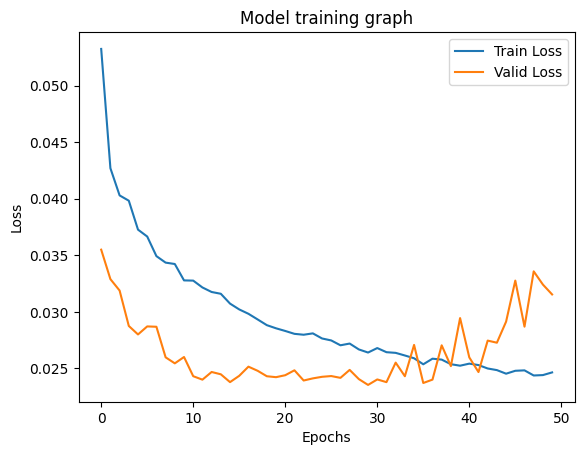

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the training graph
def plot_train_graph(train_loss_list, valid_loss_list):
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(valid_loss_list, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model training graph')
    plt.legend()
    plt.show()

plot_train_graph(train_loss_list, valid_loss_list)

In [19]:
import math

# get the best performing model weights
model.load_state_dict(torch.load('mlp.pt'))

def show_boulder(model, device, dataset):
    # grab a boulder from the validation set and see what the net thinks
    view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)
    
    # set it up properly for viewing + prediction
    board, grade = next(iter(view_iterator))
    view_board = board.reshape(18, 11, 2)
    view_grade = grade.reshape(7)
    board = board.to(device)
    grade = grade.to(device)
    print_board(view_board, view_grade.numpy())
    pred = model.eval()(board)[0].cpu()
    pred_numpy = pred.detach().numpy().reshape(7)
    pred_sig_numpy = torch.sigmoid(pred).detach().numpy().reshape(7)
    rounded_pred = np.round(pred_sig_numpy, 1)
    thresholded_pred = tuple(1 if x > 0 else 0 for x in pred_numpy)
    print(f"NN Estimation: {list_to_grade[thresholded_pred]}")
    print(f"Full correct class: {view_grade.numpy()}")
    print(f"Model estim. class: {rounded_pred}")

show_boulder(model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | E - - - - - - - - - - 
17 | - - - M - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - - - - M - 
12 | - - - - - - - - - - - 
11 | - - - - - - - M - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - - M - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - S - - - - - - - - - 
 5 | - - S - - - - - - M - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V5 (6C/+)
NN Estimation: V6 (7A)
Full correct class: [1. 0. 0. 0. 0. 0. 0.]
Model estim. class: [1.  0.8 0.4 0.2 0.  0.  0. ]


In [108]:
from sklearn.metrics import classification_report, confusion_matrix

def get_acc(y, y_pred):
    return sum([int(item == y_pred[idx]) for idx, item in enumerate(y)]) / len(y_pred)
        
def get_acc_plus_minus_one(y, y_pred):
    return sum([int(abs(item - y_pred[idx]) <= 1) for idx, item in enumerate(y)]) / len(y_pred)

# metrics generator for model
def get_metrics(model, iterator, device, thresholds=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]):

    ticklabels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11+"]

    model.eval()

    cf_pred = []
    cf_true = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Getting model metrics / generating report", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            # convert prediction vector into class
            for idx, item in enumerate(y_pred):
                true_y = y[idx]
                max_idx_pred = sum([int(F.sigmoid(x) > thresholds[i]) for i, x in enumerate(item)])
                max_idx_true = sum([int(x > 0) for i, x in enumerate(true_y)])
                cf_pred.append(max_idx_pred)
                cf_true.append(max_idx_true)

    print(f"Accuracy: {get_acc(cf_true, cf_pred):.2%} | Accuracy +- 1: {get_acc_plus_minus_one(cf_true, cf_pred):.2%}")
    print(classification_report(cf_true, cf_pred, target_names=ticklabels, digits=4))
    cf_matrix = confusion_matrix(cf_true, cf_pred)
    cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
    ax.set(xlabel="Predicted Labels", ylabel="True Labels")
    plt.show()

Training set metrics:


Accuracy: 58.33% | Accuracy +- 1: 94.68%
              precision    recall  f1-score   support

          V4     0.8471    0.7399    0.7899      6229
          V5     0.5357    0.5026    0.5186      4244
          V6     0.3558    0.4198    0.3851      1939
          V7     0.2804    0.5067    0.3610      1115
          V8     0.5971    0.3925    0.4736      1488
          V9     0.3292    0.8111    0.4683       360
         V10     0.9160    0.3234    0.4781       337
        V11+     0.9795    0.9931    0.9862       144

    accuracy                         0.5833     15856
   macro avg     0.6051    0.5861    0.5576     15856
weighted avg     0.6313    0.5833    0.5958     15856



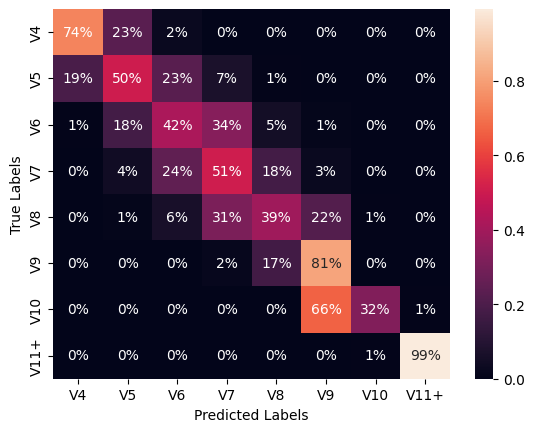

Validation set metrics:


Accuracy: 53.12% | Accuracy +- 1: 92.23%
              precision    recall  f1-score   support

          V4     0.8477    0.7404    0.7904      1556
          V5     0.4985    0.4713    0.4845      1061
          V6     0.2750    0.3340    0.3017       485
          V7     0.2265    0.4050    0.2905       279
          V8     0.4553    0.3145    0.3720       372
          V9     0.2128    0.4444    0.2878        90
         V10     0.2400    0.1429    0.1791        84
        V11+     0.5000    0.2500    0.3333        36

    accuracy                         0.5312      3963
   macro avg     0.4070    0.3878    0.3799      3963
weighted avg     0.5731    0.5312    0.5457      3963



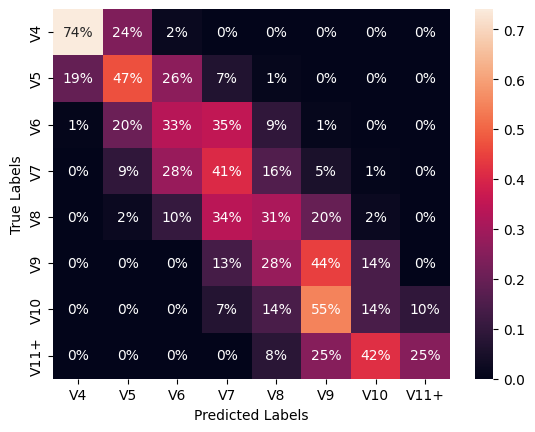

In [109]:
# get metrics
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)

valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(model, valid_cf_iter, device)

In [119]:
# fix the random seed; don't modify this
torch.manual_seed(23459078)

# now try training the CNN model and check the stats
cnn_model = CNN(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)

cnn_model = cnn_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(cnn_model, 'cnn', train_iterator, valid_iterator, criterion, device)

Number of trainable parameters: 256,711


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.04890 | Train Acc:  35.34% | Train Acc +/- 1 Grade:  70.77%
	 Val. Loss: 0.03254 |  Val. Acc:  49.45% |  Val. Acc +/- 1 Grade:  86.27%


Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.03428 | Train Acc:  45.27% | Train Acc +/- 1 Grade:  85.13%
	 Val. Loss: 0.02517 |  Val. Acc:  55.06% |  Val. Acc +/- 1 Grade:  90.83%


Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.02960 | Train Acc:  48.68% | Train Acc +/- 1 Grade:  88.84%
	 Val. Loss: 0.02568 |  Val. Acc:  50.12% |  Val. Acc +/- 1 Grade:  90.10%


Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.02704 | Train Acc:  50.86% | Train Acc +/- 1 Grade:  90.60%
	 Val. Loss: 0.02411 |  Val. Acc:  51.42% |  Val. Acc +/- 1 Grade:  92.20%


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.02541 | Train Acc:  52.22% | Train Acc +/- 1 Grade:  91.86%
	 Val. Loss: 0.02588 |  Val. Acc:  47.30% |  Val. Acc +/- 1 Grade:  90.62%


Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.02500 | Train Acc:  53.13% | Train Acc +/- 1 Grade:  92.02%
	 Val. Loss: 0.02409 |  Val. Acc:  50.49% |  Val. Acc +/- 1 Grade:  92.10%


Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.02370 | Train Acc:  54.76% | Train Acc +/- 1 Grade:  92.84%
	 Val. Loss: 0.02298 |  Val. Acc:  53.40% |  Val. Acc +/- 1 Grade:  92.32%


Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.02356 | Train Acc:  54.35% | Train Acc +/- 1 Grade:  92.65%
	 Val. Loss: 0.02427 |  Val. Acc:  50.70% |  Val. Acc +/- 1 Grade:  91.46%


Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.02296 | Train Acc:  55.58% | Train Acc +/- 1 Grade:  93.56%
	 Val. Loss: 0.02454 |  Val. Acc:  49.79% |  Val. Acc +/- 1 Grade:  90.80%


Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.02241 | Train Acc:  56.33% | Train Acc +/- 1 Grade:  93.67%
	 Val. Loss: 0.02500 |  Val. Acc:  48.80% |  Val. Acc +/- 1 Grade:  91.15%


Epoch: 11 | Epoch Time: 0m 5s
	Train Loss: 0.02206 | Train Acc:  56.45% | Train Acc +/- 1 Grade:  93.71%
	 Val. Loss: 0.02253 |  Val. Acc:  54.33% |  Val. Acc +/- 1 Grade:  93.37%


Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.02170 | Train Acc:  57.02% | Train Acc +/- 1 Grade:  93.84%
	 Val. Loss: 0.02419 |  Val. Acc:  49.25% |  Val. Acc +/- 1 Grade:  92.26%


Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.02166 | Train Acc:  57.35% | Train Acc +/- 1 Grade:  93.89%
	 Val. Loss: 0.02538 |  Val. Acc:  47.06% |  Val. Acc +/- 1 Grade:  91.82%


Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.02080 | Train Acc:  58.17% | Train Acc +/- 1 Grade:  94.66%
	 Val. Loss: 0.02287 |  Val. Acc:  53.66% |  Val. Acc +/- 1 Grade:  93.33%


Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.02059 | Train Acc:  58.50% | Train Acc +/- 1 Grade:  94.70%
	 Val. Loss: 0.02342 |  Val. Acc:  52.73% |  Val. Acc +/- 1 Grade:  92.67%


Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.02069 | Train Acc:  58.57% | Train Acc +/- 1 Grade:  94.75%
	 Val. Loss: 0.02441 |  Val. Acc:  49.81% |  Val. Acc +/- 1 Grade:  92.09%


Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.02072 | Train Acc:  58.31% | Train Acc +/- 1 Grade:  94.68%
	 Val. Loss: 0.02311 |  Val. Acc:  53.22% |  Val. Acc +/- 1 Grade:  93.04%


Epoch: 18 | Epoch Time: 0m 5s
	Train Loss: 0.02081 | Train Acc:  58.55% | Train Acc +/- 1 Grade:  94.90%
	 Val. Loss: 0.02595 |  Val. Acc:  46.73% |  Val. Acc +/- 1 Grade:  91.20%


Epoch: 19 | Epoch Time: 0m 5s
	Train Loss: 0.02030 | Train Acc:  59.37% | Train Acc +/- 1 Grade:  95.00%
	 Val. Loss: 0.02434 |  Val. Acc:  51.19% |  Val. Acc +/- 1 Grade:  92.12%


Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.02020 | Train Acc:  59.32% | Train Acc +/- 1 Grade:  94.99%
	 Val. Loss: 0.02418 |  Val. Acc:  51.14% |  Val. Acc +/- 1 Grade:  92.67%


Epoch: 21 | Epoch Time: 0m 5s
	Train Loss: 0.02019 | Train Acc:  59.38% | Train Acc +/- 1 Grade:  94.82%
	 Val. Loss: 0.02406 |  Val. Acc:  51.27% |  Val. Acc +/- 1 Grade:  92.29%


Epoch: 22 | Epoch Time: 0m 5s
	Train Loss: 0.01958 | Train Acc:  60.72% | Train Acc +/- 1 Grade:  95.18%
	 Val. Loss: 0.02479 |  Val. Acc:  49.69% |  Val. Acc +/- 1 Grade:  92.26%


Epoch: 23 | Epoch Time: 0m 6s
	Train Loss: 0.01977 | Train Acc:  59.96% | Train Acc +/- 1 Grade:  95.11%
	 Val. Loss: 0.02651 |  Val. Acc:  46.18% |  Val. Acc +/- 1 Grade:  91.10%


Epoch: 24 | Epoch Time: 0m 5s
	Train Loss: 0.01996 | Train Acc:  60.09% | Train Acc +/- 1 Grade:  95.30%
	 Val. Loss: 0.02397 |  Val. Acc:  51.92% |  Val. Acc +/- 1 Grade:  92.69%


KeyboardInterrupt: 

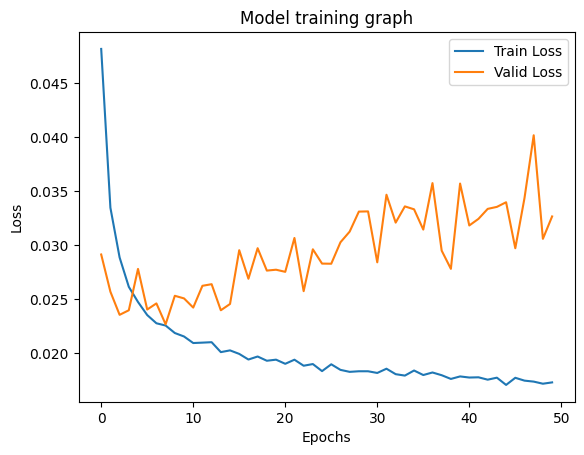

In [23]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [120]:
# get the best performing model weights
cnn_model.load_state_dict(torch.load('cnn.pt'))

# show a boulder
show_boulder(cnn_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - E - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - M - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - M - - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - M - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - S - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V5 (6C/+)
NN Estimation: V6 (7A)
Full correct class: [1. 0. 0. 0. 0. 0. 0.]
Model estim. class: [0.9 0.5 0.2 0.  0.  0.  0. ]


Training set metrics:


Accuracy: 63.08% | Accuracy +- 1: 97.17%
              precision    recall  f1-score   support

          V4     0.8659    0.7431    0.7998      6229
          V5     0.5581    0.5151    0.5357      4244
          V6     0.3944    0.5972    0.4751      1939
          V7     0.3464    0.5462    0.4239      1115
          V8     0.7787    0.4657    0.5828      1488
          V9     0.5460    0.7750    0.6406       360
         V10     0.8812    0.9021    0.8915       337
        V11+     0.9412    1.0000    0.9697       144

    accuracy                         0.6308     15856
   macro avg     0.6640    0.6931    0.6649     15856
weighted avg     0.6749    0.6308    0.6425     15856



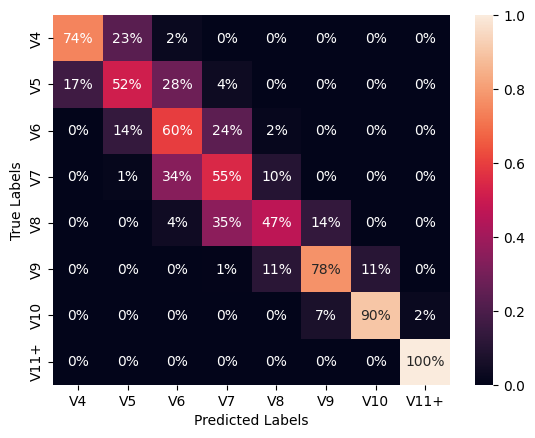

Validation set metrics:


Accuracy: 54.35% | Accuracy +- 1: 93.36%
              precision    recall  f1-score   support

          V4     0.8575    0.7461    0.7979      1556
          V5     0.5120    0.4618    0.4856      1061
          V6     0.2972    0.4577    0.3604       485
          V7     0.2489    0.3978    0.3062       279
          V8     0.4640    0.2769    0.3468       372
          V9     0.2331    0.4222    0.3004        90
         V10     0.3750    0.2500    0.3000        84
        V11+     0.4444    0.2222    0.2963        36

    accuracy                         0.5435      3963
   macro avg     0.4290    0.4044    0.3992      3963
weighted avg     0.5885    0.5435    0.5574      3963



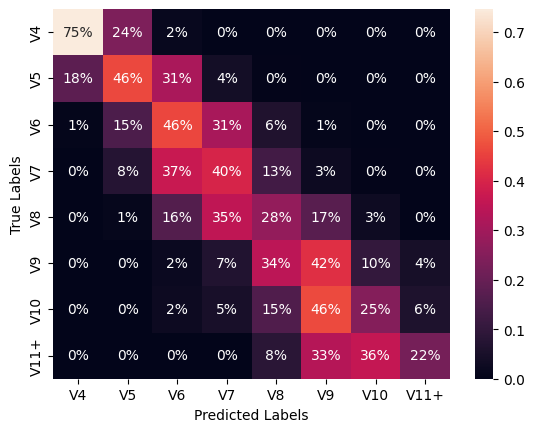

In [121]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(cnn_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(cnn_model, valid_cf_iter, device)

In [115]:
# fix the random seed; don't modify this
torch.manual_seed(23459078)

# now try training the ResNet model and check the stats
resnet_model = ResNet(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-3, weight_decay=5e-5)

resnet_model = resnet_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(resnet_model, 'resnet', train_iterator, valid_iterator, criterion, device)

Number of trainable parameters: 151,047


Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.05271 | Train Acc:  32.69% | Train Acc +/- 1 Grade:  66.58%
	 Val. Loss: 0.03223 |  Val. Acc:  48.29% |  Val. Acc +/- 1 Grade:  82.00%


Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.04181 | Train Acc:  38.26% | Train Acc +/- 1 Grade:  77.09%
	 Val. Loss: 0.02972 |  Val. Acc:  49.75% |  Val. Acc +/- 1 Grade:  84.99%


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.03553 | Train Acc:  42.19% | Train Acc +/- 1 Grade:  82.61%
	 Val. Loss: 0.02611 |  Val. Acc:  52.76% |  Val. Acc +/- 1 Grade:  88.04%


Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.03250 | Train Acc:  44.10% | Train Acc +/- 1 Grade:  85.12%
	 Val. Loss: 0.02345 |  Val. Acc:  54.96% |  Val. Acc +/- 1 Grade:  91.26%


Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.02998 | Train Acc:  47.17% | Train Acc +/- 1 Grade:  87.57%
	 Val. Loss: 0.02309 |  Val. Acc:  56.87% |  Val. Acc +/- 1 Grade:  91.53%


Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.02866 | Train Acc:  47.95% | Train Acc +/- 1 Grade:  88.42%
	 Val. Loss: 0.02306 |  Val. Acc:  57.77% |  Val. Acc +/- 1 Grade:  91.33%


Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.02795 | Train Acc:  48.54% | Train Acc +/- 1 Grade:  89.45%
	 Val. Loss: 0.02231 |  Val. Acc:  57.59% |  Val. Acc +/- 1 Grade:  91.26%


Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.02668 | Train Acc:  50.55% | Train Acc +/- 1 Grade:  90.18%
	 Val. Loss: 0.02317 |  Val. Acc:  57.59% |  Val. Acc +/- 1 Grade:  90.90%


Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.02649 | Train Acc:  50.72% | Train Acc +/- 1 Grade:  90.24%
	 Val. Loss: 0.02323 |  Val. Acc:  56.52% |  Val. Acc +/- 1 Grade:  90.81%


Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.02605 | Train Acc:  50.93% | Train Acc +/- 1 Grade:  90.65%
	 Val. Loss: 0.02208 |  Val. Acc:  55.45% |  Val. Acc +/- 1 Grade:  92.14%


Epoch: 11 | Epoch Time: 0m 9s
	Train Loss: 0.02571 | Train Acc:  51.49% | Train Acc +/- 1 Grade:  91.20%
	 Val. Loss: 0.02244 |  Val. Acc:  55.26% |  Val. Acc +/- 1 Grade:  92.21%


Epoch: 12 | Epoch Time: 0m 9s
	Train Loss: 0.02531 | Train Acc:  51.97% | Train Acc +/- 1 Grade:  91.18%
	 Val. Loss: 0.02149 |  Val. Acc:  58.33% |  Val. Acc +/- 1 Grade:  92.78%


Epoch: 13 | Epoch Time: 0m 8s
	Train Loss: 0.02510 | Train Acc:  52.38% | Train Acc +/- 1 Grade:  91.59%
	 Val. Loss: 0.02341 |  Val. Acc:  57.66% |  Val. Acc +/- 1 Grade:  90.73%


Epoch: 14 | Epoch Time: 0m 8s
	Train Loss: 0.02474 | Train Acc:  53.12% | Train Acc +/- 1 Grade:  91.44%
	 Val. Loss: 0.02229 |  Val. Acc:  58.17% |  Val. Acc +/- 1 Grade:  91.39%


Epoch: 15 | Epoch Time: 0m 8s
	Train Loss: 0.02437 | Train Acc:  53.53% | Train Acc +/- 1 Grade:  92.10%
	 Val. Loss: 0.02324 |  Val. Acc:  57.45% |  Val. Acc +/- 1 Grade:  91.16%


Epoch: 16 | Epoch Time: 0m 11s
	Train Loss: 0.02384 | Train Acc:  53.83% | Train Acc +/- 1 Grade:  92.39%
	 Val. Loss: 0.02416 |  Val. Acc:  57.16% |  Val. Acc +/- 1 Grade:  91.14%


Epoch: 17 | Epoch Time: 0m 9s
	Train Loss: 0.02361 | Train Acc:  53.87% | Train Acc +/- 1 Grade:  92.71%
	 Val. Loss: 0.02229 |  Val. Acc:  57.78% |  Val. Acc +/- 1 Grade:  91.97%


Epoch: 18 | Epoch Time: 0m 8s
	Train Loss: 0.02360 | Train Acc:  54.45% | Train Acc +/- 1 Grade:  92.41%
	 Val. Loss: 0.02249 |  Val. Acc:  57.96% |  Val. Acc +/- 1 Grade:  92.02%


Epoch: 19 | Epoch Time: 0m 8s
	Train Loss: 0.02353 | Train Acc:  54.83% | Train Acc +/- 1 Grade:  92.62%
	 Val. Loss: 0.02326 |  Val. Acc:  56.00% |  Val. Acc +/- 1 Grade:  91.15%


Epoch: 20 | Epoch Time: 0m 8s
	Train Loss: 0.02323 | Train Acc:  55.22% | Train Acc +/- 1 Grade:  93.10%
	 Val. Loss: 0.02328 |  Val. Acc:  57.40% |  Val. Acc +/- 1 Grade:  92.10%


Epoch: 21 | Epoch Time: 0m 8s
	Train Loss: 0.02310 | Train Acc:  55.09% | Train Acc +/- 1 Grade:  92.97%
	 Val. Loss: 0.02468 |  Val. Acc:  56.54% |  Val. Acc +/- 1 Grade:  91.08%


Epoch: 22 | Epoch Time: 0m 9s
	Train Loss: 0.02310 | Train Acc:  55.32% | Train Acc +/- 1 Grade:  92.96%
	 Val. Loss: 0.02462 |  Val. Acc:  57.50% |  Val. Acc +/- 1 Grade:  91.14%


Epoch: 23 | Epoch Time: 0m 8s
	Train Loss: 0.02295 | Train Acc:  54.69% | Train Acc +/- 1 Grade:  93.34%
	 Val. Loss: 0.02163 |  Val. Acc:  58.21% |  Val. Acc +/- 1 Grade:  92.65%


Epoch: 24 | Epoch Time: 0m 8s
	Train Loss: 0.02273 | Train Acc:  55.45% | Train Acc +/- 1 Grade:  93.37%
	 Val. Loss: 0.02228 |  Val. Acc:  58.04% |  Val. Acc +/- 1 Grade:  92.20%


Epoch: 25 | Epoch Time: 0m 8s
	Train Loss: 0.02263 | Train Acc:  56.02% | Train Acc +/- 1 Grade:  93.53%
	 Val. Loss: 0.02243 |  Val. Acc:  58.67% |  Val. Acc +/- 1 Grade:  91.89%


Epoch: 26 | Epoch Time: 0m 8s
	Train Loss: 0.02229 | Train Acc:  56.04% | Train Acc +/- 1 Grade:  93.35%
	 Val. Loss: 0.02221 |  Val. Acc:  57.99% |  Val. Acc +/- 1 Grade:  92.25%


Epoch: 27 | Epoch Time: 0m 8s
	Train Loss: 0.02250 | Train Acc:  55.80% | Train Acc +/- 1 Grade:  93.42%
	 Val. Loss: 0.02205 |  Val. Acc:  57.83% |  Val. Acc +/- 1 Grade:  92.15%


Epoch: 28 | Epoch Time: 0m 8s
	Train Loss: 0.02257 | Train Acc:  56.53% | Train Acc +/- 1 Grade:  93.45%
	 Val. Loss: 0.02218 |  Val. Acc:  58.28% |  Val. Acc +/- 1 Grade:  91.89%


Epoch: 29 | Epoch Time: 0m 8s
	Train Loss: 0.02209 | Train Acc:  56.55% | Train Acc +/- 1 Grade:  93.80%
	 Val. Loss: 0.02180 |  Val. Acc:  58.59% |  Val. Acc +/- 1 Grade:  92.83%


Epoch: 30 | Epoch Time: 0m 8s
	Train Loss: 0.02232 | Train Acc:  56.26% | Train Acc +/- 1 Grade:  93.76%
	 Val. Loss: 0.02453 |  Val. Acc:  57.44% |  Val. Acc +/- 1 Grade:  90.81%


Epoch: 31 | Epoch Time: 0m 8s
	Train Loss: 0.02182 | Train Acc:  56.66% | Train Acc +/- 1 Grade:  93.93%
	 Val. Loss: 0.02326 |  Val. Acc:  57.90% |  Val. Acc +/- 1 Grade:  91.84%


Epoch: 32 | Epoch Time: 0m 8s
	Train Loss: 0.02163 | Train Acc:  57.15% | Train Acc +/- 1 Grade:  94.05%
	 Val. Loss: 0.02289 |  Val. Acc:  58.64% |  Val. Acc +/- 1 Grade:  91.86%


Epoch: 33 | Epoch Time: 0m 8s
	Train Loss: 0.02260 | Train Acc:  56.60% | Train Acc +/- 1 Grade:  93.66%
	 Val. Loss: 0.02372 |  Val. Acc:  58.54% |  Val. Acc +/- 1 Grade:  90.75%


Epoch: 34 | Epoch Time: 0m 10s
	Train Loss: 0.02188 | Train Acc:  56.85% | Train Acc +/- 1 Grade:  93.96%
	 Val. Loss: 0.02427 |  Val. Acc:  58.08% |  Val. Acc +/- 1 Grade:  91.28%


Epoch: 35 | Epoch Time: 0m 9s
	Train Loss: 0.02148 | Train Acc:  57.64% | Train Acc +/- 1 Grade:  93.98%
	 Val. Loss: 0.03027 |  Val. Acc:  56.24% |  Val. Acc +/- 1 Grade:  89.52%


KeyboardInterrupt: 

In [ ]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [116]:
# get the best performing model weights
resnet_model.load_state_dict(torch.load('resnet.pt'))

# show a boulder
show_boulder(resnet_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - - - E - - - - 
17 | - - - - - - - - - - - 
16 | - - - - M - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - M - - - - 
13 | - - - - - M - - - - - 
12 | - - - - - - - - - M - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - M - - 
 9 | - - - - - - - - - - M 
 8 | - - M - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - S 
 5 | - - - - - - - S - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V5 (6C/+)
NN Estimation: V5 (6C/+)
Full correct class: [1. 0. 0. 0. 0. 0. 0.]
Model estim. class: [0.6 0.1 0.  0.  0.  0.  0. ]


Training set metrics:


Accuracy: 62.70% | Accuracy +- 1: 95.59%
              precision    recall  f1-score   support

          V4     0.7905    0.8740    0.8301      6229
          V5     0.6003    0.4604    0.5211      4244
          V6     0.4064    0.5142    0.4540      1939
          V7     0.3045    0.3309    0.3171      1115
          V8     0.6000    0.3528    0.4444      1488
          V9     0.3788    0.6944    0.4902       360
         V10     0.7611    0.7656    0.7633       337
        V11+     0.8229    1.0000    0.9028       144

    accuracy                         0.6270     15856
   macro avg     0.5830    0.6240    0.5904     15856
weighted avg     0.6309    0.6270    0.6207     15856



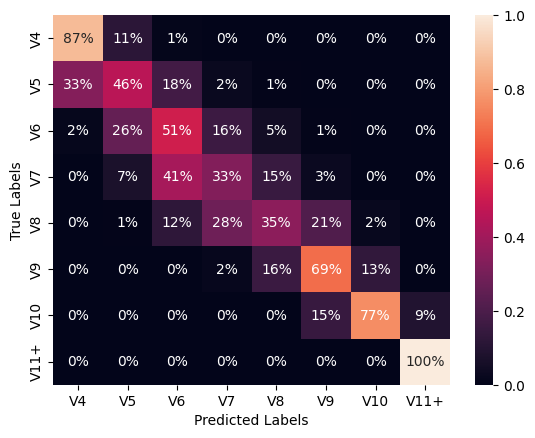

Validation set metrics:


Accuracy: 58.36% | Accuracy +- 1: 92.81%
              precision    recall  f1-score   support

          V4     0.7906    0.8785    0.8323      1556
          V5     0.5693    0.4298    0.4898      1061
          V6     0.3476    0.4536    0.3936       485
          V7     0.2646    0.2760    0.2702       279
          V8     0.4664    0.2984    0.3639       372
          V9     0.2321    0.4333    0.3023        90
         V10     0.3846    0.3571    0.3704        84
        V11+     0.5200    0.3611    0.4262        36

    accuracy                         0.5836      3963
   macro avg     0.4469    0.4360    0.4311      3963
weighted avg     0.5859    0.5836    0.5778      3963



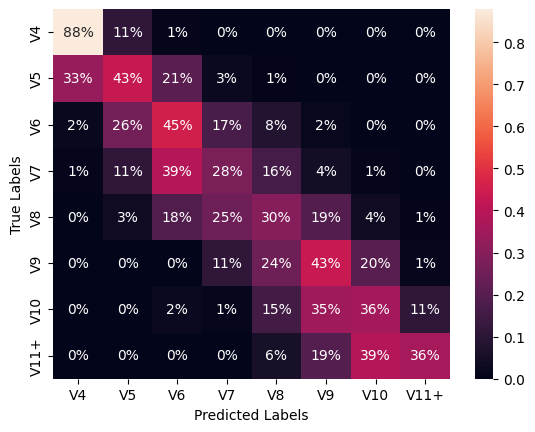

In [117]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(resnet_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(resnet_model, valid_cf_iter, device)

In [124]:
# save using onnx runtime for inference (only available for MLP since the CNN and the ResNet both use adaptive Max-Pooling)
view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)

board, grade = next(iter(view_iterator))
model = model.to(device)
board = board.to(device)
torch.onnx.export(model,                     # model being run
                  board,                     # model input (or a tuple for multiple inputs)
                  "moonboard_clf-mlp.onnx",  # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                            # the ONNX version to export the model to
                    # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [125]:
# save the other models for inference
torch.save(cnn_model, 'moonboard-clf-cnn.pth')
torch.save(resnet_model, 'moonboard-clf-resnet.pth')